# Skin Cancer Dataset
A training set for academic machine learning can be created using the dataset, which comprises of 10015 dermatoscopic images. All significant diagnostic categories for pigmented lesions are represented in the cases in a representative manner:
# Types Of Skin:
1. Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),

2. basal cell carcinoma (bcc),

3. benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
4. dermatofibroma (df),
5. melanoma (mel),
6. melanocytic nevi (nv) and
7. vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

Histopathology (histo) is used to confirm more than 50% of lesions; in the remaining cases, follow-up exams, expert consensus, or in-vivo confocal microscopy confirmation are used as the gold standard (confocal).

Dataset Collected from:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

In [1]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

2024-05-22 10:02:36.604449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 10:02:36.604604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 10:02:36.751682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
meta_data = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
meta_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [3]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [4]:
meta_data.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

In [5]:
meta_data.isnull()

lesion_id  image_id     dx  dx_type    age    sex  localization
0          False     False  False    False  False  False         False
1          False     False  False    False  False  False         False
2          False     False  False    False  False  False         False
3          False     False  False    False  False  False         False
4          False     False  False    False  False  False         False
...          ...       ...    ...      ...    ...    ...           ...
10010      False     False  False    False  False  False         False
10011      False     False  False    False  False  False         False
10012      False     False  False    False  False  False         False
10013      False     False  False    False  False  False         False
10014      False     False  False    False  False  False         False

[10015 rows x 7 columns]

In [6]:
print("Unique Cancer types represented in data.")
print(meta_data.dx.unique(),"\n")

# Handling categorical data
encoder = LabelEncoder()
meta_data["dx_label"] = encoder.fit_transform(meta_data["dx"])

# Display of labels and their integer encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data.
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [7]:
meta_data.head()

lesion_id      image_id   dx dx_type   age   sex localization  dx_label
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp         2
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp         2
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp         2
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp         2
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear         2

In [8]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dx_label      10015 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 626.1+ KB


In [9]:
# Sorting images into appropriate directories in order
# to fascilitate real-time data augmentation while training.

# Using the cancer type label for directory creation.
dir_names = encoder.transform(encoder.classes_)

# Data Sorting process.
images_dir = r"/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"
train_images_dir = r"/kaggle/working/train/"


def create_dirs(dir_path:str, dir_names:list):
    """
    This function creates directories within specified directory path
    with the provided list of directory names.
    
    Inputs
        dir_path:str - The path to which the new directories will reside in.
        dir_names:list - List name(s) of directories to be created.
    """
    # Looping through to create directories in new location.
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue

            
# Creating new directories. 
create_dirs(train_images_dir, dir_names)

# Looping through each image in previous folder and
# assigning them to the appropriate folder
for image in os.scandir(images_dir):
    try:
        # attempting to rename image (moving to new dir).
        img_name = image.name.split(".")[0]
        img_cancer_type = str(meta_data.dx_label[meta_data.image_id == img_name].item()) # Retrieving the dx_label for image.
        shutil.copy(os.path.join(images_dir, image.name), os.path.join(train_images_dir, img_cancer_type, image.name))
    except Exception as e:
        print(e)


In [10]:
# ==========================================================================================#
# DO NOT RE-RUN THIS CELL MULTIPLE TIMES IF VALIDATION DIRECTORY HAS ALREADY BEEN POPULATED #
# ==========================================================================================#

validation_images_dir = r"/kaggle/working/validation/"
inds = [] # list to contain directory names of each image.
five_percent_content = {} # Dictionary containing cancer type and the value that is 5% of total number of that type of cancer images.

# Finding out how many images of each cancer type exist
for dir_name in os.scandir(train_images_dir): # Iterating over all train images folders.
    for cancer_img in os.scandir(dir_name): # Iterating over all images in all folders.
        inds.append(cancer_img.path.split("/")[4]) # Appending each images directro number to inds for counting & sorting purpose.
        

# Calculating number of specific type images &
# Calculating what 5% of each image type will be.
for directory in dir_names:
    total_amt = inds.count(str(directory))
    c_type = encoder.inverse_transform([int(directory)])[0]
    print(f"There are {total_amt} images of {c_type} cancer.")
    print(f"5% of {c_type} cancer images is: {round(total_amt * 0.05, 0)}\n")
    five_percent_content[str(directory)] = round(total_amt * 0.05, 0)


# Creating and populating validation set directory
create_dirs(validation_images_dir, dir_names)


# Moving 5% of each type into its respective validation folder.
# Looping through each sub directory
for sub_dir in os.scandir(train_images_dir):
    # Getting all images in current subdir
    images_paths = [image.path for image in os.scandir(sub_dir)]
    # Extracting 5% of images from each directory.
    for image_path in images_paths[: int(five_percent_content[str(sub_dir.name)])]:
        # Getting category for individual images
        image_category = image_path.split("/")[4]
        # creating new image path and moving old image to new destination.
        shutil.move(image_path, os.path.join(validation_images_dir, image_category, image_path.split("/")[-1]))
# ==========================================================================================#
# DO NOT RE-RUN THIS CELL MULTIPLE TIMES IF VALIDATION DIRECTORY HAS ALREADY BEEN POPULATED #
# ==========================================================================================#

There are 327 images of akiec cancer.
5% of akiec cancer images is: 16.0

There are 514 images of bcc cancer.
5% of bcc cancer images is: 26.0

There are 1099 images of bkl cancer.
5% of bkl cancer images is: 55.0

There are 115 images of df cancer.
5% of df cancer images is: 6.0

There are 1113 images of mel cancer.
5% of mel cancer images is: 56.0

There are 6705 images of nv cancer.
5% of nv cancer images is: 335.0

There are 142 images of vasc cancer.
5% of vasc cancer images is: 7.0



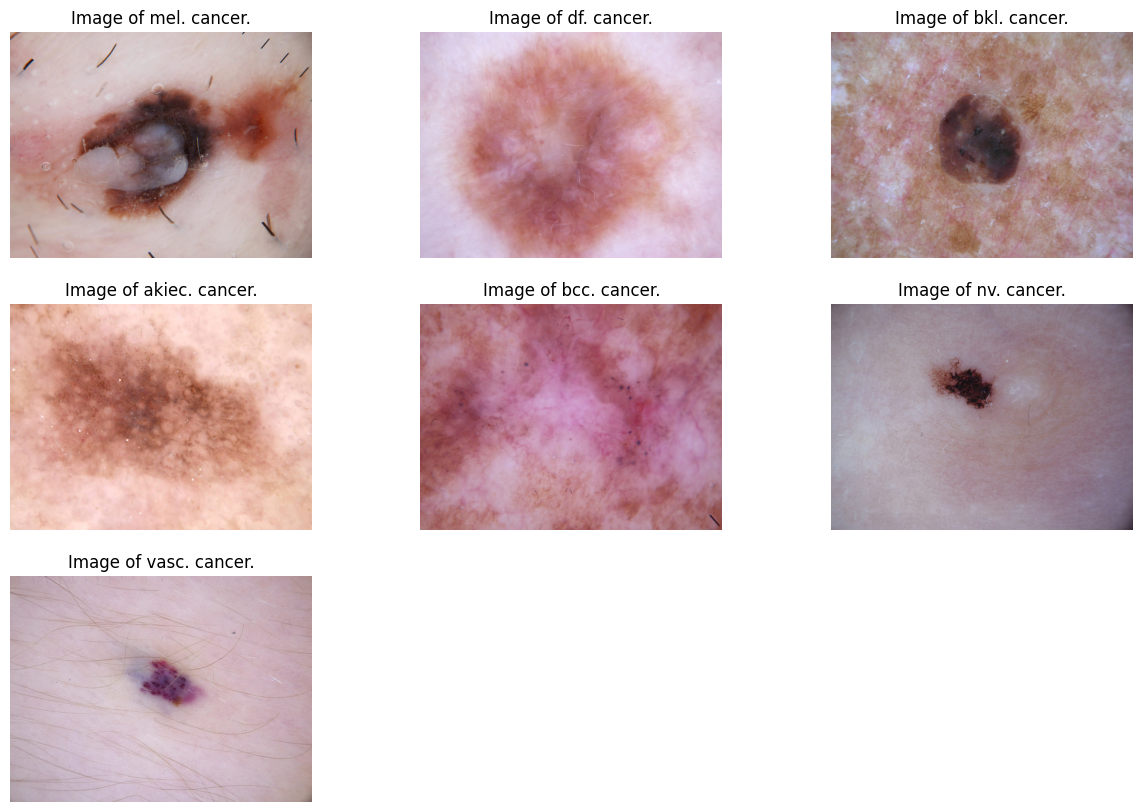

In [11]:
top_n = 20 # Variable for top-n random images to select from.
image_sample = [] # List containing array of images.
image_sample_category = [] # List containing image type

for sub_dir in os.scandir(train_images_dir):
    # Getting all images in current subdir
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = [] # List of top n images from current sub-dir.
    # Extracting random image from each directory.
    for image_path in images_paths[:top_n]:
        current_dir_img_paths.append(image_path) # Appending images from current sub-dir to orary list
        image = random.choice(current_dir_img_paths) # Selecting random image from current images.
        image = cv2.imread(image)[:,:,::-1] # Reading in image and arranging colors.
    image_sample_category.append((encoder.inverse_transform([int(image_path.split("/")[4])])[0])) # Appending image category name to array.
    image_sample.append(image) # Appending image array to list.
        

plt.figure(figsize = (15,10))
for num in range(0, len(image_sample)):
    plt.subplot(3, 3 ,num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}. cancer.")
    plt.imshow(image_sample[num]);

In [12]:
img_size = 250 # Augmented image size.
batch_size = 32

generator = ImageDataGenerator(zoom_range = 0.3,
                               rotation_range = 90,
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.1,)

# Augmented training set
augmented_train_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "training")

# Un-augmented test set
unaugmented_test_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            subset = "validation")

# Un-augmented dev set.
unaugmented_dev_data = image_dataset_from_directory(
                            validation_images_dir,
                            image_size = (img_size, img_size),
                            batch_size = batch_size)

Found 8566 images belonging to 7 classes.
Found 948 images belonging to 7 classes.
Found 501 files belonging to 7 classes.


In [13]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [14]:
def plot_label_count (df, column):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    plt.figure(figsize=(20,5))
    form = {'family': 'serif', 'color': 'blue', 'size': 25} 
    plt.bar(labels, values)
    plt.title('Images per label', fontsize= 24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Labels", fontdict=form)
    plt.ylabel('Number of Images', fontdict=form)
    plt.show()

In [15]:
def make_dataframes(csvpath, source_dir, trsplit): 
    df=pd.read_csv(csvpath)
    df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization'], axis=1)
    df.columns=['filepaths', 'labels']   
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(source_dir,x + '.jpg'))
    print('length of dataframe is ', len(df))    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count
  
csvpath=r'../input/skin-cancer-dataset/HAM10000_metadata.csv'
source_dir=r'../input/skin-cancer-dataset/Skin Cancer/Skin Cancer'
trsplit=.8
train_df, test_df, valid_df, classes, class_count=make_dataframes(csvpath, source_dir, trsplit)

length of dataframe is  10015
number of classes in processed dataset=  7
the maximum files in any class in train_df is  5364   the minimum files in any class in train_df is  92
train_df length:  8012   test_df length:  1002   valid_df length:  1001
average image height=  450   average image width=  600  aspect ratio h/w=  0.75


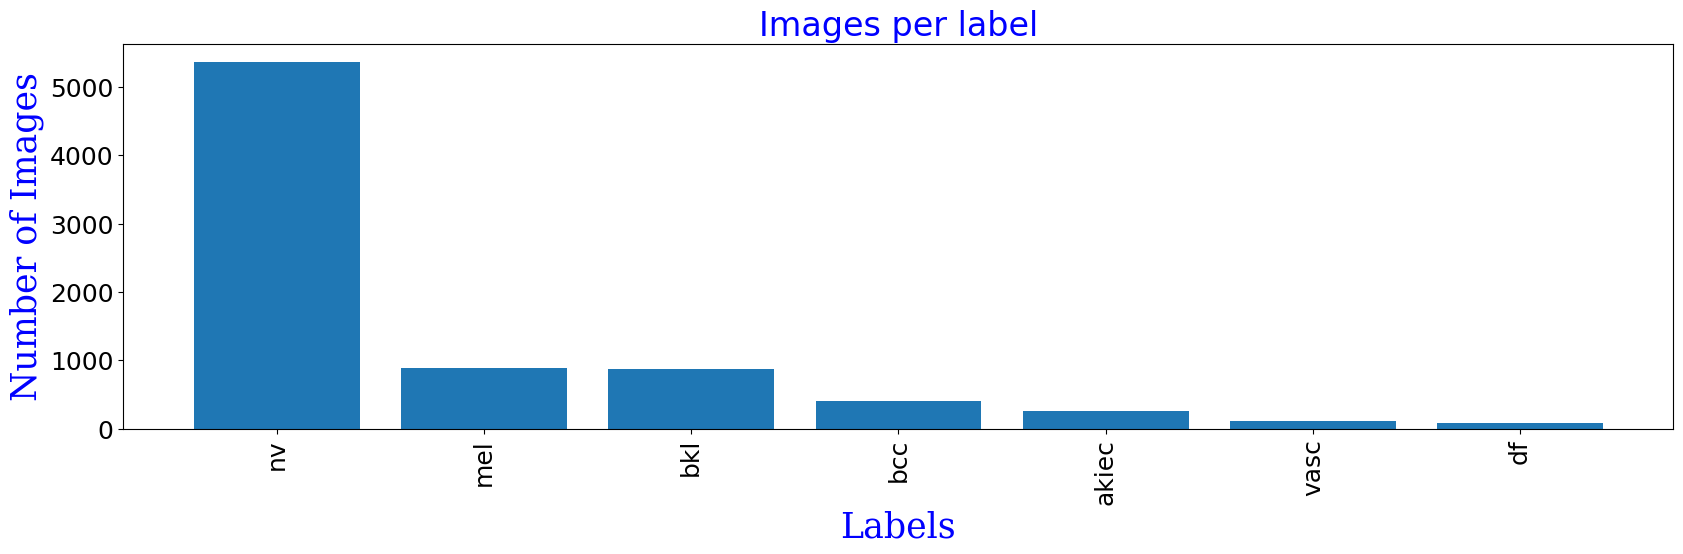

In [16]:
# lets look at the number of images in each label for the train_df dataframe
if len(train_df['labels'].unique())<20: # Over 20 labels the plot is to hard to understand
    plot_label_count (train_df, 'labels')

In [17]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=200
min_samples=92
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  8012  with  7  classes
after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  92
the trimmed dataframe now is of length  1206  with  7  classes


In [18]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 


n=300 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,300) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)  

Initial length of dataframe is  1206
Found 200 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.
Found 92 validated image filenames.
Found 114 validated image filenames.
Total Augmented images created=  894
Length of augmented dataframe is now  2100


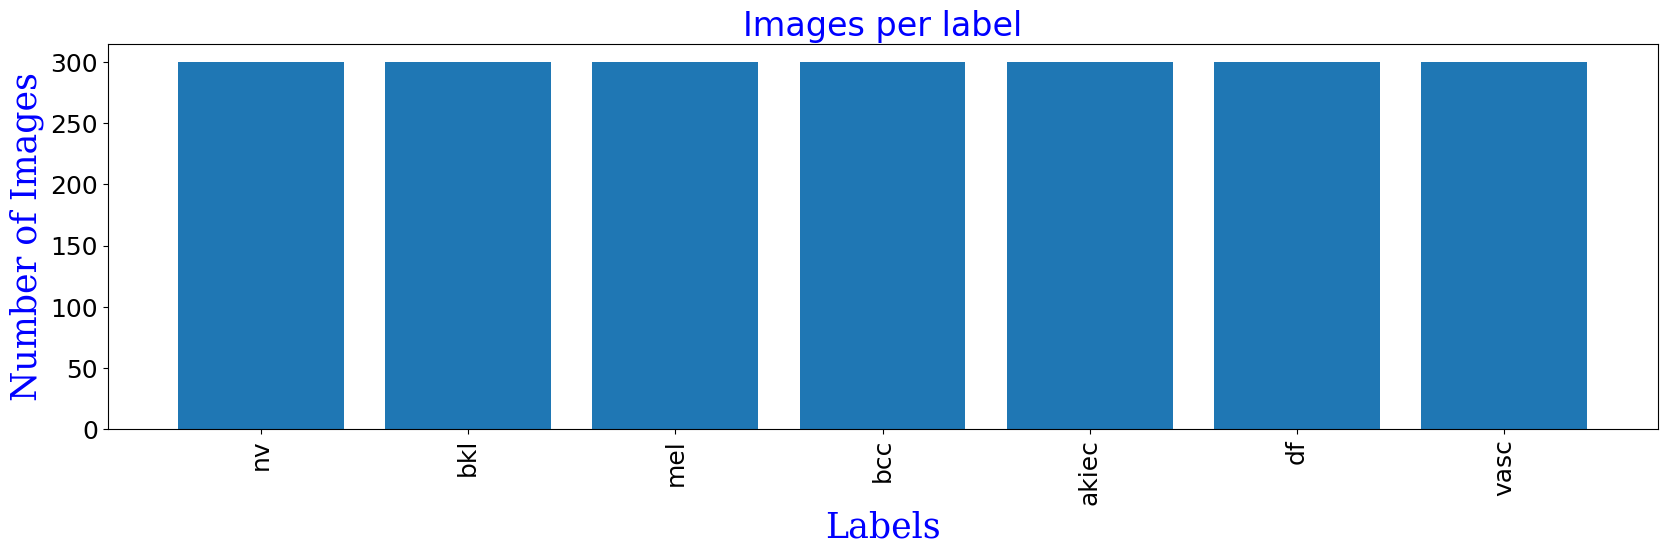

In [19]:
# lets look at train_df after balancing
if len(train_df['labels'].unique())<20: # Over 20 labels the plot is to hard to understand
    plot_label_count (train_df, 'labels')

In [20]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps


batch_size=30
train_gen, test_gen, valid_gen,  test_steps =make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 2100 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
test batch size:  6   test steps:  167  number of classes :  7


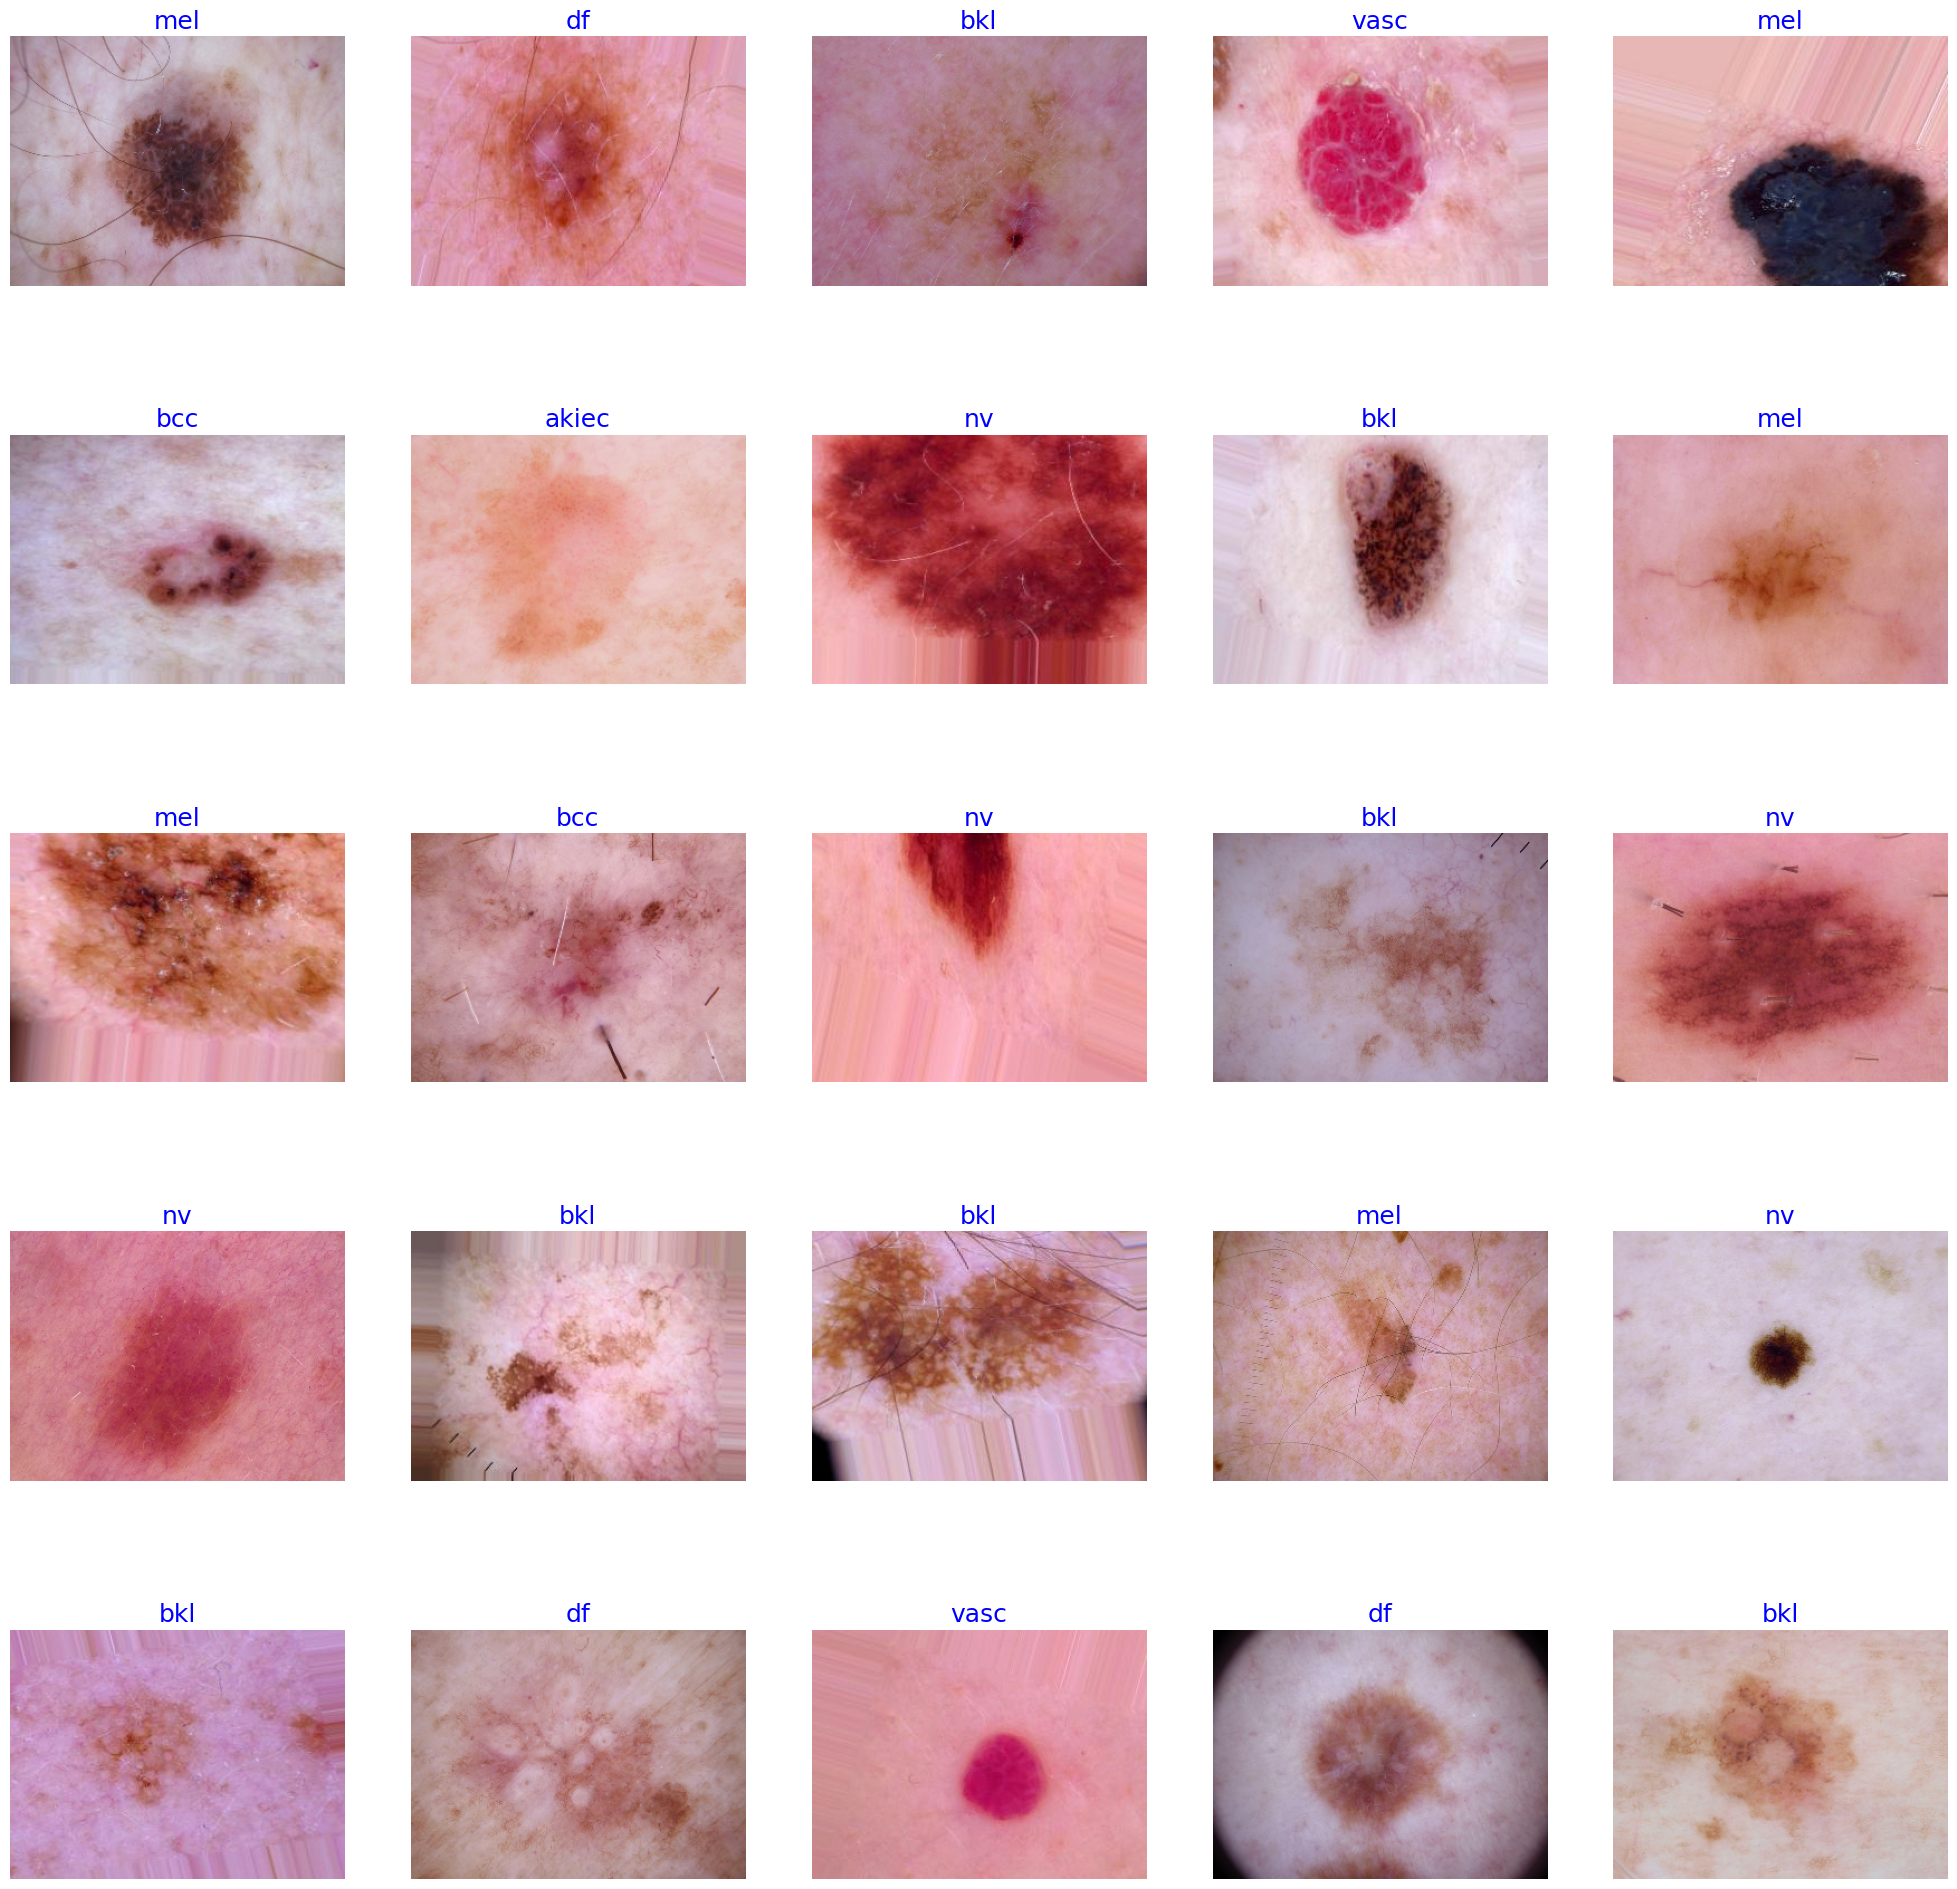

In [21]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )